# KNN으로 포지션 예측하기

In [289]:
# Random값을 정하기
import numpy as np
np.random.seed(5)

In [290]:
import pandas as pd 

In [291]:
train = pd.read_csv('../Data/basketball_train.csv')
test = pd.read_csv('../Data/basketball_test.csv')

In [292]:
train.head()

,Player,Pos,3P,TRB,BLK
0,Andre Drummond,C,0.0,13.8,1.1
1,Jordan Clarkson,SG,1.4,3.0,0.1
2,Robin Lopez,C,0.0,6.4,1.4
3,Nicolas Batum,SG,1.8,6.2,0.4
4,Salah Mejri,C,0.0,4.2,0.8


In [293]:
test.head()

,Player,Pos,3P,TRB,BLK
0,Bismack Biyombo,C,0.0,7.0,1.1
1,Georgios Papagiannis,C,0.0,3.9,0.8
2,Avery Bradley,SG,2.0,6.1,0.2
3,Pau Gasol,C,0.9,7.8,1.1
4,Mason Plumlee,C,0.0,7.5,1.1


In [294]:
print(train.shape)
print(train.count())
print(train.isnull().sum())

(80, 5)
Player    80
Pos       80
3P        80
TRB       80
BLK       80
dtype: int64
Player    0
Pos       0
3P        0
TRB       0
BLK       0
dtype: int64


In [295]:
print(test.shape)
print(test.count())
print(test.isnull().sum())

(20, 5)
Player    20
Pos       20
3P        20
TRB       20
BLK       20
dtype: int64
Player    0
Pos       0
3P        0
TRB       0
BLK       0
dtype: int64


### 최적의 k 찾기 (교차검증 - cross validation)

In [296]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # 교차검증

In [297]:
# 최적의 k를 찾기 위해 교차 검증을 수행할 k의 범위를 3부터 학습데이터의 절반까지 지정
max_k_range = train.shape[0]  // 2
max_k_range

40

In [298]:
# 최적의 k를 찾기 위한 범위 확인
k_list = []
for i in range(3, max_k_range, 2):
    k_list.append(i)
k_list

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

In [299]:
# 점수 및 Train Data 정의
cross_validation_scores = []
x_train = train[['3P', 'BLK', 'TRB']]
y_train = train['Pos']

print(x_train.head())
print(y_train.head())

    3P  BLK   TRB
0  0.0  1.1  13.8
1  1.4  0.1   3.0
2  0.0  1.4   6.4
3  1.8  0.4   6.2
4  0.0  0.8   4.2
0     C
1    SG
2     C
3    SG
4     C
Name: Pos, dtype: object


---

In [300]:
# 교차검증(10-fold)을 각 k를 대상으로 수행해 검증 결과를 저장

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(
        knn,
        x_train,
        y_train,
        cv=10,    # cv : cross validation(교차검증 횟수)
        scoring='accuracy'
    )
    cross_validation_scores.append(scores.mean())
cross_validation_scores

[0.9,
 0.925,
 0.9125,
 0.9125,
 0.9125,
 0.9125,
 0.9125,
 0.9,
 0.9125,
 0.9,
 0.875,
 0.8875,
 0.875,
 0.85,
 0.8375,
 0.8375,
 0.8375,
 0.8125,
 0.775]

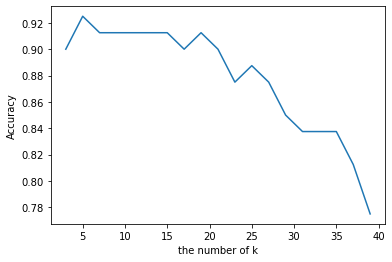

In [301]:
# k에 따른 정확도를 시각화
import matplotlib.pyplot as plt

plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [302]:
# 가장 예측률이 높은 k를 선정
cvs = cross_validation_scores
k = k_list[cvs.index(max(cross_validation_scores))]  # 최대값의 인덱스
print('The best number of k is', k)

The best number of k is 5


---
### 2개의 특징으로 예측하기(3점슛, 블로킹)

In [303]:
from sklearn.neighbors import KNeighborsClassifier

In [304]:
knn = KNeighborsClassifier(n_neighbors=k)

In [305]:
# 학습에 사용할 features
x_train = train[['3P', 'BLK']]

In [306]:
# 학습에 사용할 target
y_train = train['Pos']

In [307]:
# 학습시키키
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [308]:
# 검증에 사용할 features
x_test = test[['3P', 'BLK']]

In [309]:
# 검증에 사용할 정답
y_test = test['Pos']

In [310]:
knn.score(x_test, y_test)

0.95

In [311]:
# 예측
pred = knn.predict(x_test)
pred

array(['C', 'C', 'SG', 'C', 'C', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'C',
       'C', 'SG', 'SG', 'SG', 'SG', 'SG', 'C', 'C'], dtype=object)

In [312]:
# 실제값과 예측값의 비교
comparision = pd.DataFrame(
    {'예측값':pred,
     '정답':y_test
    }
)
comparision.head()

,예측값,정답
0,C,C
1,C,C
2,SG,SG
3,C,C
4,C,C


# Comfusion matrix

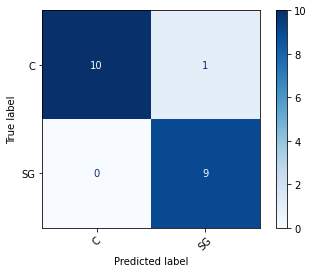

In [313]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix1 = confusion_matrix(y_test, pred)
target_names = ["C", "SG"]
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix1,
    display_labels=target_names
)
disp.plot(
    cmap=plt.cm.Blues,
    xticks_rotation=45
)
plt.show()

---
### 3개의 특징으로 예측하기 (3점슛, 블로킹, 리바운드)

In [314]:
# 학습에 사용할 features
x_train = train[['3P','BLK','TRB']]
y_train = train['Pos']

In [315]:
# 검증에 사용할 features
x_test = test[['3P','BLK','TRB']]
y_test = test['Pos']

In [316]:
# 학습시키키
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [317]:
# 검증
knn.score(x_test, y_test)

0.9

In [318]:
# 예측
pred = knn.predict(x_test)
pred

array(['C', 'C', 'C', 'C', 'C', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'C',
       'C', 'SG', 'SG', 'SG', 'SG', 'SG', 'C', 'C'], dtype=object)

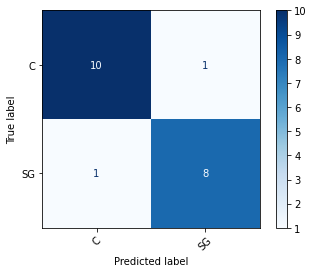

In [319]:
confusion_matrix2 = confusion_matrix(y_test, pred)
target_names = ["C", "SG"]
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix2,
    display_labels=target_names
)
disp.plot(
    cmap=plt.cm.Blues,
    xticks_rotation=45
)
plt.show()

In [320]:
print(knn.predict([[3.4, 0.5, 3.7]])[0])

SG
